# ICU Care Units Traversal
## Agenda
1. **End-Point Traversals**
  * Explore *distribution* of `first` & `last` care units.
  * Identify the *probability* of end-point transfer pairs.
    * **Overall Probability** of transfer pairs in relation to all possibilities.
    * **Probability of `Previous CU`** for each ICU type. 
2. Multiple Traversals: **All Wards**
  * Determine the *count* of total ward transfers per hospital admission and whether it has any correlation with ICU readmission.
  * Identify the *probability* of `prev_careunit` & `curr_careunit` transfer pairs.
    * **Overall Probability** of transfer pairs in relation to all possibilities.
    * **Probability of `Previous CU`** for each ICU type. 
3. Multiple Traversals: **ICU Wards**
  * Determine the *count* of ICU ward transfers per hospital admission and whether it has any correlation with ICU readmission.
  * Identify the *probability* of `prev_careunit` & `curr_careunit` transfer pairs.
    * **Overall Probability** of transfer pairs in relation to all possibilities.
    * **Probability of `Previous CU`** for each ICU type. 
  * **Side Study 1**: Determine if there's any correlation between *multiple transfers* in the same ICU stay and the number of ICU readmissions.
  * **Side Study 2**: Determine if the time of ICU admission (day/night) has any relationship with ICU readmissions.

In [1]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

In [2]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=True):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

## Identify Patients with ICU Readmissions 
Each unique patient (`subject_id`) & their corresponding number of icustays (readmission: n<sub>ICU stay</sub> > 1).

In [3]:
# query
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
icu_pat = exec_query(q_icupat, False)
df_icu_pat = pd.DataFrame(icu_pat, columns=['subjectid', 'n_icustays'])
df_icu_pat

,subjectid,n_icustays
0,7,2
1,17,2
2,21,2
3,23,2
4,34,2
5,36,3
6,41,2
7,61,2
8,67,2
9,68,3


# Care Unit Traversals

#### Unique Combinations
n<sub>unique combo</sub> = `(n!) / (k! (n - k)!)`
  * **n**: number of sample points in a set
  * **k**: number of sample points in each combination

n<sub>ICU combo</sub> = (5!) / (2! (5-2)!) = **10 possible unique ICU traversal pairs**

#### Important Notes:
  * Care Units are defined based off the `WARDID` being associated with an ICU cost center. Thus, each ICU (`PREV_CAREUNIT` and `CURR_CAREUNIT`) is associated with a `WARDID`, but *not every* `WARDID` is an ICU.
  * Definition of a `WARDID` is not consistent. ICUs in the Beth Israel Deaconess Hospital moved throughout the year.
  
### Care Unit Types
  1. Mobile Intensive Care Unit (`MICU`)
  2. Cardiac Surgery Recovery Unit (`CSRU`)
  3. Surgical Intensive Care Unit (`SICU`)
  4. Neonatal Intensive Care Unit (`NICU`)
  5. Cardiac Care Unit (`CCU`)
  6. Trauma Surgical Intensive Care Unit (`TSICU`)

**Note**: Exclusion of `NICU` (minors)

## End-Point Traversal: Admission (`First`) - Discharge (`Last`)
Transfer pairs of admission and discharge ICUs for readmitted ICU patients.

### Distribution of First & Last Care Units
Frequency of a care unit's use by ICU readmitted patients for admission and discharge (end-points).

In [4]:
# query
q_cu = """SELECT subject_id, first_careunit, last_careunit
    FROM icustays;"""

# Query output
cu = exec_query(q_cu, False)
df_cu = pd.DataFrame(cu, 
                           columns=['subjectid', 'first_cu', 'last_cu'])

# filter for readmitted ICU patients
filter_preadm = list(df_icu_pat.subjectid)
df_cu_readm = df_cu[df_cu.subjectid.isin(filter_preadm)]

# map number of icustays to each patient
num_icur_map = df_icu_pat.set_index('subjectid').to_dict()['n_icustays']
num_icur = pd.Series(df_cu_readm.subjectid.map(num_icur_map), name='n_icustays')
df_cu_readm = pd.concat([df_cu_readm, num_icur], axis=1)

# Number of ICU readmitted patients per CU
fcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['first_cu']).agg('count')
lcu_ct = df_cu_readm['subjectid'].groupby(df_cu_readm['last_cu']).agg('count')
fcu_ct.name = 'fcu_n_icustays'
lcu_ct.name = 'lcu_n_icustays'

# Extract percentages
fcur_perc = (fcu_ct / fcu_ct.sum() * 100).round(decimals=2)
fcur_perc.name = 'fcu_perc'
lcur_perc = (lcu_ct / lcu_ct.sum() * 100).round(decimals=2)
lcur_perc.name = 'lcu_perc'

df_cu_readm_grp = pd.concat([fcu_ct, lcu_ct, fcur_perc, lcur_perc], axis=1)
df_cu_readm_grp.sort_values('fcu_perc', ascending=False)

,fcu_n_icustays,lcu_n_icustays,fcu_perc,lcu_perc
MICU,10917,11052,45.85,46.42
SICU,3962,4080,16.64,17.13
CCU,3449,3385,14.48,14.22
CSRU,3175,3132,13.33,13.15
TSICU,1854,1708,7.79,7.17
NICU,454,454,1.91,1.91


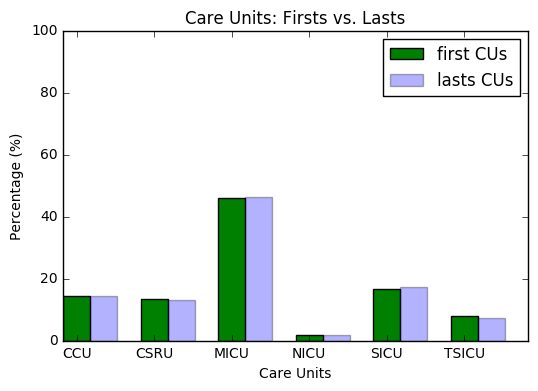

In [5]:
fig, ax = plt.subplots()
index = np.arange(6)
bar_width=0.35

rects1 = plt.bar(index, df_cu_readm_grp.fcu_perc, bar_width,
        alpha=1.0, color='g', label='first CUs')
rects2 = plt.bar(index + bar_width, df_cu_readm_grp.lcu_perc, bar_width,
        alpha=0.3, color='b', label='lasts CUs')
plt.xlabel('Care Units')
plt.ylabel('Percentage (%)')
plt.ylim([0, 100])
plt.xticks(index + bar_width/2, df_cu_readm_grp.index)
plt.legend()
plt.title('Care Units: Firsts vs. Lasts')
plt.show()

**Results**:
  * Similar distributions amongsts care units for both admission (`first_careunits`) and discharge (`last_careunits`).
  * **Mobile Intensive Care Unit (`MICU`)** account for majority of admissions & discharge of readmitted ICU patients (~45-46%).

### Count & Overall Probability of End-Point Transfer Pairs
**Overall Probability**: The probability/percentage of a transfer pair in relation to overall possibilities.

In [6]:
df_cu_readm = df_cu_readm[df_cu_readm['first_cu'] != 'NICU']
df_cu_readm = df_cu_readm[df_cu_readm['last_cu'] != 'NICU']
df_cu_readm['trans']=df_cu_readm.first_cu+'-'+df_cu_readm.last_cu
df_cu_readm

,subjectid,first_cu,last_cu,n_icustays,trans
0,109,MICU,MICU,38,MICU-MICU
1,109,MICU,MICU,38,MICU-MICU
2,109,MICU,SICU,38,MICU-SICU
3,109,SICU,MICU,38,SICU-MICU
4,109,MICU,MICU,38,MICU-MICU
5,109,MICU,MICU,38,MICU-MICU
6,109,MICU,MICU,38,MICU-MICU
7,109,SICU,SICU,38,SICU-SICU
8,109,SICU,SICU,38,SICU-SICU
9,109,MICU,MICU,38,MICU-MICU


In [7]:
df_readm_trans=df_cu_readm.groupby(['trans'])
df_readm_trans.size().sort_values(ascending=False)
df_readm_trans = df_readm_trans.size().to_frame(name='n_trans')
df_readm_trans = df_readm_trans.reset_index()
df_cu_trans_endpt = pd.Series(df_readm_trans.n_trans / df_readm_trans.n_trans.sum(), 
                              name='perc_trans')
df_readm_trans = pd.concat([df_readm_trans, df_cu_trans_endpt], axis=1)
df_readm_trans.sort_values('perc_trans', ascending=False)

,trans,n_trans,perc_trans
12,MICU-MICU,10411,0.445734
18,SICU-SICU,3674,0.157298
0,CCU-CCU,3013,0.128998
6,CSRU-CSRU,2890,0.123732
24,TSICU-TSICU,1580,0.067646
2,CCU-MICU,228,0.009762
13,MICU-SICU,221,0.009462
17,SICU-MICU,183,0.007835
10,MICU-CCU,174,0.007450
1,CCU-CSRU,154,0.006593


**Results**: Majority of first-last care unit transfers occur within the same CU.

Top 5:  

|Transfer Pair| Count | %|
|:----|:---:|:--:|
|`MICU-MICU`|10411|44.6%|
|`SICU-SICU`|3674|15.7%|
|`CCU-CCU`|3013|12.9%|
|`CSRU-CSRU`|2890|12.4%|
|`TSICU-TSICU`|1580|6.8%|


### Probability of `Admission` CU given `Discharge`
Probability of patients deriving from a particular `first CU` for a given `last CU`.

Note: Read by columns (column sum = 1.0)

In [8]:
pd.crosstab(df_cu_readm.first_cu, 
            df_cu_readm.last_cu)/pd.crosstab(df_cu_readm.first_cu, 
                                             df_cu_readm.last_cu).sum()

last_cu,CCU,CSRU,MICU,SICU,TSICU
first_cu,,,,,
CCU,0.890103,0.049170,0.020630,0.010294,0.007026
CSRU,0.036928,0.922733,0.008415,0.012500,0.009368
MICU,0.051403,0.015326,0.942001,0.054167,0.036885
SICU,0.012408,0.008301,0.016558,0.900490,0.021663
TSICU,0.009158,0.004470,0.012396,0.022549,0.925059


**Results**:
  * Patients are most likely to be *discharged* from the same care unit type that they were *admitted* into (~90% probability). 
    * Thus, suggesting that most patients likely have 1 ICU stay with no transfers to another care unit for that given stay.

# Multiple Traversals
Explore full-scope of transfers between wards, *inclusive of admission, transfer, and discharge events*.

In [9]:
q_mult= """SELECT subject_id, hadm_id, icustay_id, eventtype,
prev_careunit, curr_careunit, prev_wardid, curr_wardid, intime, outtime, los
FROM transfers;"""
mult_trav = exec_query(q_mult, False)
mult_col = ['subjectid', 'hadmid', 'icustayid', 'eventtype', 'prev_cu', 'curr_cu', 
       'prev_wardid', 'curr_wardid', 'intime', 'outtime', 'los']
df_mult = pd.DataFrame(mult_trav, columns = mult_col)
df_mult.replace(to_replace='', value=np.nan, inplace=True, regex=True)

# filter for ICU patients with readmission
df_mult_readm = df_mult[df_mult.subjectid.isin(filter_preadm)]

# filter for exclusion of neonate patients
df_mult_readm = df_mult_readm[df_mult_readm['prev_cu'] != 'NWARD']
df_mult_readm = df_mult_readm[df_mult_readm['prev_cu'] != 'NICU']
df_mult_readm = df_mult_readm[df_mult_readm['curr_cu'] != 'NWARD']
df_mult_readm = df_mult_readm[df_mult_readm['curr_cu'] != 'NICU']
df_mult_readm.sort_values('subjectid')

,subjectid,hadmid,icustayid,eventtype,prev_cu,curr_cu,prev_wardid,curr_wardid,intime,outtime,los
281,17,194023,NaN,discharge,NaN,NaN,55.0,NaN,2134-12-31 16:02:59,NaT,NaN
280,17,194023,NaN,transfer,CSRU,NaN,12.0,55.0,2134-12-29 18:04:03,2134-12-31 16:02:59,45.98
282,17,161087,257980.0,admit,NaN,CSRU,NaN,12.0,2135-05-09 14:12:06,2135-05-10 11:18:34,21.11
283,17,161087,NaN,transfer,CSRU,NaN,12.0,55.0,2135-05-10 11:18:34,2135-05-10 11:35:02,0.27
284,17,161087,NaN,transfer,NaN,NaN,55.0,55.0,2135-05-10 11:35:02,2135-05-13 14:38:23,75.06
285,17,161087,NaN,discharge,NaN,NaN,55.0,NaN,2135-05-13 14:38:23,NaT,NaN
279,17,194023,277042.0,transfer,NaN,CSRU,27.0,12.0,2134-12-27 16:21:48,2134-12-29 18:04:03,49.70
278,17,194023,NaN,admit,NaN,NaN,NaN,27.0,2134-12-27 03:42:19,2134-12-27 16:21:48,12.66
298,21,109451,NaN,transfer,NaN,NaN,17.0,32.0,2134-09-11 14:11:40,2134-09-11 20:50:04,6.64
297,21,109451,NaN,admit,NaN,NaN,NaN,17.0,2134-09-11 12:18:39,2134-09-11 14:11:40,1.88


## Traversals between *All* Wards
Grouped Data by `subject_id` and `hadm_id` to obtain the number of traversals between **wards** (not exclusive to just ICU wards) for each hospital admission (`hadm`) of the patients.

### Count of Ward Traversals per Hospital Admission
Total transfers between wards for each Hospital Admission

In [10]:
df_mult_readm_grp = df_mult_readm.groupby(['subjectid', 'hadmid']).size()
df_mult_readm_grp = df_mult_readm_grp.to_frame(name='n_trav').reset_index()

# join DF on subjectid to add n_icustays col
df_mult_readm_grp1 = pd.merge(df_mult_readm_grp, df_icu_pat, on='subjectid', 
                        how='left')

# Convert n_icustays col to n_readm col
df_mult_readm_grp1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_grp1.n_readm = df_mult_readm_grp1.n_readm - 1 # transformation

df_mult_readm_grp1.sort_values('n_readm', ascending=False)

,subjectid,hadmid,n_trav,n_readm
5618,13033,170185,3,40
5606,13033,147192,3,40
5629,13033,198347,3,40
5605,13033,144350,3,40
5588,13033,106376,3,40
5589,13033,106445,5,40
5617,13033,168452,3,40
5599,13033,132307,5,40
5590,13033,107337,3,40
5591,13033,107456,6,40


#### Summary Statistics

In [11]:
df_mult_readm_grp1.describe()

,subjectid,hadmid,n_trav,n_readm
count,20117.000000,20117.000000,20117.000000,20117.000000
mean,32946.976935,149866.829746,4.805190,2.839837
std,27760.514932,28893.466974,2.234951,4.003639
min,17.000000,100001.000000,1.000000,1.000000
25%,11698.000000,124987.000000,3.000000,1.000000
50%,23707.000000,149840.000000,4.000000,2.000000
75%,52034.000000,174557.000000,6.000000,3.000000
max,99982.000000,199995.000000,25.000000,40.000000


In [12]:
print "Average Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.mean()
print "Standard Deviation Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.std()
print "Median Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.median()
print "Max Ward Transfers %.2f" % df_mult_readm_grp1.n_trav.max()

Average Ward Transfers 4.81
Standard Deviation Ward Transfers 2.23
Median Ward Transfers 4.00
Max Ward Transfers 25.00


#### Distribution of Ward Transfers

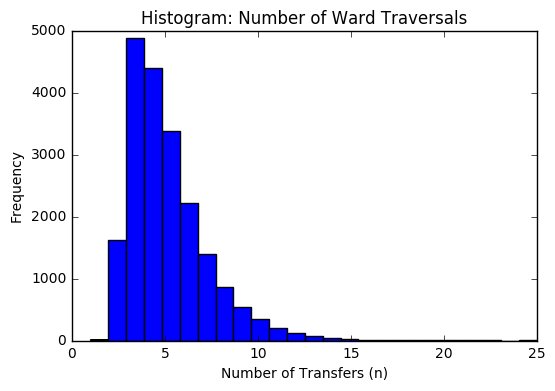

In [13]:
plt.hist(df_mult_readm_grp1.n_trav, bins=25)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of Ward Traversals')
plt.show()

The number of ward traversals in a hospital admission has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (4.8 transfers) > median (4.00 transfers).

#### Correlation: n<sub>Ward Transfers</sub> vs. n<sub>ICU Readmissions</sub>

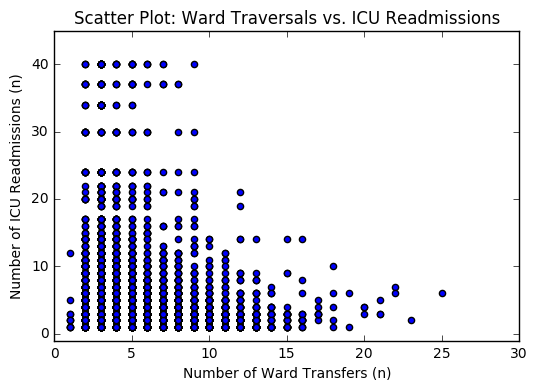

In [14]:
plt.scatter(df_mult_readm_grp1.n_trav, df_mult_readm_grp1.n_readm)
plt.xlabel('Number of Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
plt.xlim([0, 30])
plt.ylim([-1, 45])
plt.title('Scatter Plot: Ward Traversals vs. ICU Readmissions')
plt.show()

In [15]:
pear_ward_trav = df_mult_readm_grp1.corr(method='pearson').loc['n_trav', 'n_readm']
spear_ward_trav = df_mult_readm_grp1.corr(method='spearman').loc['n_trav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_ward_trav
print "Spearman Correlation Coefficient %.3f" % spear_ward_trav

Pearson Correlation Coefficient -0.074
Spearman Correlation Coefficient -0.083


The two variables (`n`<sub>all ward traversals</sub> and `n`<sub>ICU readmissions</sub>) have a very weak correlation, if any, as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients.

### Ward Transfer Pairs

#### Count & Overall Probability of Pairs
Frequency of ward transfer pairs.

In [16]:
df_mult_readm_alltrans = df_mult_readm.copy()
df_mult_readm_alltrans.prev_cu.fillna('nonicu', inplace=True)
df_mult_readm_alltrans.curr_cu.fillna('nonicu', inplace=True)
df_mult_readm_alltrans['trans'] = df_mult_readm_alltrans.prev_cu+'-'+df_mult_readm_alltrans.curr_cu
df_mult_readm_alltrans

df_readm_alltrans=df_mult_readm_alltrans.groupby(['trans'])
df_alltrans_n = df_readm_alltrans.size().to_frame(name='n_trans').reset_index()
df_alltrans_perc = pd.Series(df_alltrans_n.n_trans / df_alltrans_n.n_trans.sum(), 
                              name='perc_trans')
df_alltrans = pd.concat([df_alltrans_n, df_alltrans_perc], axis=1)
df_alltrans.sort_values('perc_trans', ascending=False)

,trans,n_trans,perc_trans
35,nonicu-nonicu,41247,0.426696
17,MICU-nonicu,11806,0.122132
32,nonicu-MICU,11580,0.119794
23,SICU-nonicu,4342,0.044918
33,nonicu-SICU,4284,0.044318
30,nonicu-CCU,3702,0.038297
5,CCU-nonicu,3681,0.038080
31,nonicu-CSRU,3458,0.035773
11,CSRU-nonicu,3340,0.034552
34,nonicu-TSICU,1988,0.020566


**Result**: Most of transfers into or out of a ICU involved a non-ICU ward. Both direction of transfers between a particular ICU ward and non-ICU are symmetrical. 
  * It should also be noted that majority of transfers involved non-ICU wards.

|Transfer Pairs| Count | % |
|:---|:--:|:--:|
|MICU/nonICU|23386|24.2|
|SICU/nonICU|8626|8.9|
|CCU/nonICU|7383|7.6|
|CSRU/nonICU|6798|7.1|
|TSICU/nonICU|3828|4.0|

#### Probability of Previous CU per Current CU
Probability of deriving CUs for each current CU.

In [17]:
pd.crosstab(
    df_mult_readm_alltrans.prev_cu, 
    df_mult_readm_alltrans.curr_cu)/(pd.crosstab(
    df_mult_readm_alltrans.prev_cu, 
    df_mult_readm_alltrans.curr_cu).sum())

curr_cu,CCU,CSRU,MICU,SICU,TSICU,nonicu
prev_cu,,,,,,
CCU,0.058462,0.029022,0.018337,0.009021,0.008323,0.055557
CSRU,0.039126,0.230929,0.008767,0.011963,0.007491,0.050411
MICU,0.039126,0.012852,0.100891,0.036478,0.032043,0.178188
SICU,0.012056,0.006633,0.015488,0.083742,0.014149,0.065534
TSICU,0.009099,0.003731,0.010520,0.018631,0.110695,0.027771
nonicu,0.842129,0.716833,0.845996,0.840165,0.827299,0.622540


Align with overall probability, patients in their current CU most likely derived from a non-ICU ward and subsequently the same type as their current ICU ward.

## Traversals to *only* ICU Wards
Transfers between only ICU wards, which are considered an ICU stay (`icustay_id`).

**Objective**: Identify any relationship between the number of *ICU transfers*  and the number of ICU readmissions per hospital admission.

In [18]:
df_mult_readm_icu = df_mult_readm[df_mult_readm.icustayid.notnull()==True]
df_mult_readm_icu

,subjectid,hadmid,icustayid,eventtype,prev_cu,curr_cu,prev_wardid,curr_wardid,intime,outtime,los
6,34,115799,263086.0,transfer,NaN,MICU,17.0,23.0,2186-07-18 18:10:49,2186-07-19 11:27:20,17.28
9,34,144319,290505.0,admit,NaN,CCU,NaN,7.0,2191-02-23 05:25:32,2191-02-23 05:33:33,0.13
11,34,144319,290505.0,transfer,NaN,CCU,32.0,7.0,2191-02-23 06:09:12,2191-02-24 19:24:10,37.25
21,36,182104,280987.0,transfer,NaN,CSRU,49.0,12.0,2131-05-04 10:29:14,2131-05-05 13:07:03,26.63
25,36,122659,211200.0,transfer,NaN,CSRU,55.0,15.0,2131-05-16 23:18:26,2131-05-17 06:15:36,6.95
26,36,122659,211200.0,transfer,CSRU,CSRU,15.0,15.0,2131-05-17 06:15:36,2131-05-18 11:00:06,28.74
27,36,122659,211200.0,transfer,CSRU,CSRU,15.0,15.0,2131-05-18 11:00:06,2131-05-23 19:56:11,128.93
32,36,165660,241249.0,transfer,NaN,MICU,24.0,52.0,2134-05-12 06:52:47,2134-05-16 15:14:20,104.36
53,41,101757,261027.0,transfer,NaN,SICU,3.0,57.0,2133-01-03 06:34:40,2133-01-06 16:01:33,81.45
55,41,101757,237024.0,transfer,NaN,CSRU,3.0,15.0,2133-01-09 12:18:30,2133-01-12 15:51:03,75.54


### Count of ICU Transfers within each Hospital Admission
Total icustays within each admission (inclusive of same and different icustays)

In [19]:
df_mult_readm_hadm = df_mult_readm_icu.groupby(['subjectid', 'hadmid']).size().to_frame('n_icutrav').reset_index()

# join DF  on subjectid to add n_readm col
df_mult_readm_hadm1 = pd.merge(df_mult_readm_hadm, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_hadm1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_hadm1.n_readm = df_mult_readm_hadm1.n_readm - 1 # transformation

df_mult_readm_hadm1

,subjectid,hadmid,n_icutrav,n_readm
0,17,161087,1,1
1,17,194023,1,1
2,21,109451,2,1
3,21,111970,1,1
4,23,124321,1,1
5,23,152223,1,1
6,34,115799,1,1
7,34,144319,2,1
8,36,122659,3,2
9,36,165660,1,2


#### Summary Statistics

In [20]:
print "Average ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.mean()
print "Standard Deviation ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.std()
print "Median ICU Ward Traversals %.2f" % df_mult_readm_hadm1.n_icutrav.median()
print "Max ICU Ward Traversal %.2f" % df_mult_readm_hadm1.n_icutrav.max()

df_mult_readm_hadm1.describe()

Average ICU Ward Traversals 1.54
Standard Deviation ICU Ward Traversals 0.93
Median ICU Ward Traversals 1.00
Max ICU Ward Traversal 11.00


,subjectid,hadmid,n_icutrav,n_readm
count,19719.000000,19719.000000,19719.000000,19719.000000
mean,32967.844211,149877.695877,1.542167,2.854607
std,27767.554089,28882.239436,0.931596,4.024724
min,17.000000,100001.000000,1.000000,1.000000
25%,11700.000000,125021.500000,1.000000,1.000000
50%,23707.000000,149836.000000,1.000000,2.000000
75%,52114.000000,174547.000000,2.000000,3.000000
max,99982.000000,199995.000000,11.000000,40.000000


The average transfer to ICU wards is 1.54 with a standard deviation of 0.93 for each hospital admission. Thus, patients with ICU readmission typically only have 1-2 ICU transfers in a given hospital admission.

#### Distribution of ICU Ward Transfers per HADM

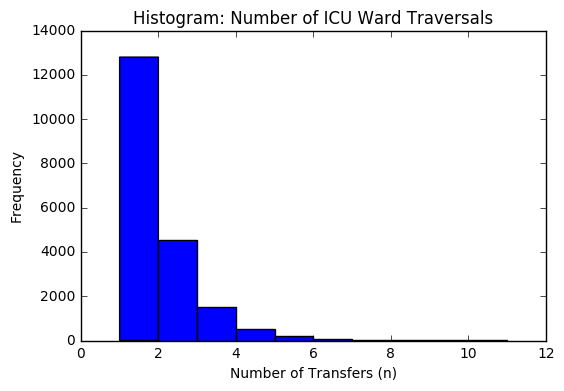

In [21]:
plt.hist(df_mult_readm_hadm1.n_icutrav, bins=10)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of ICU Ward Traversals')
plt.show()

The number of ICU ward traversals in a hospital admission has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (1.55 ICU transfers) > median (1.00 ICU transfers).

#### Correlation: ICU Ward Transfers (per HADM) vs. ICU Readmissions

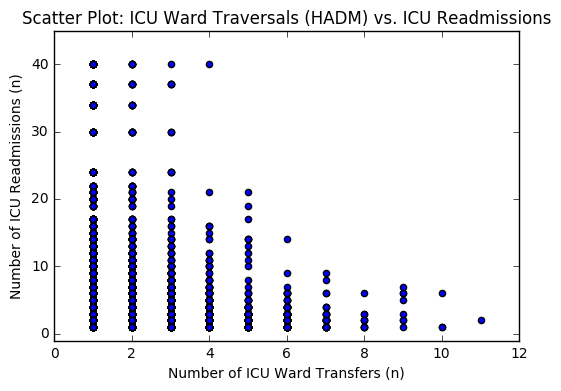

In [22]:
plt.scatter(df_mult_readm_hadm1.n_icutrav, df_mult_readm_hadm1.n_readm)
plt.xlabel('Number of ICU Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
# plt.xlim([0, 12])
plt.ylim([-1, 45])
plt.title('Scatter Plot: ICU Ward Traversals (HADM) vs. ICU Readmissions')
plt.show()

In [23]:
pear_icu_trav = df_mult_readm_hadm1.corr(method='pearson').loc['n_icutrav', 'n_readm']
spear_icu_trav = df_mult_readm_hadm1.corr(method='spearman').loc['n_icutrav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_icu_trav
print "Spearman Correlation Coefficient %.3f" % spear_icu_trav

Pearson Correlation Coefficient -0.032
Spearman Correlation Coefficient -0.032


The two variables (`n_icutrav` and `n_readm`) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients.

### ICU Transfer Pairs

#### Breakdown of `Prev_CU` - `Curr_CU` Pair

In [27]:
df_test = df_mult_readm_icu.copy()
df_test.prev_cu.fillna('NON-ICU', inplace=True)
df_test.curr_cu.fillna('NON-ICU', inplace=True)

df_transfer = df_test[df_test.eventtype == 'transfer']
df_admit = df_test[df_test.eventtype == 'admit']

df_transfer.groupby(['prev_cu', 'curr_cu', 'eventtype']).size().unstack()

eventtype        transfer
prev_cu curr_cu          
CCU     CCU           257
        CSRU          140
        MICU          251
        SICU           46
        TSICU          20
CSRU    CCU           172
        CSRU         1114
        MICU          120
        SICU           61
        TSICU          18
MICU    CCU           172
        CSRU           62
        MICU         1381
        SICU          186
        TSICU          77
NON-ICU CCU          1992
        CSRU         2857
        MICU         5124
        SICU         2844
        TSICU        1204
SICU    CCU            53
        CSRU           32
        MICU          212
        SICU          427
        TSICU          34
TSICU   CCU            40
        CSRU           18
        MICU          144
        SICU           95
        TSICU         266

`MICU` appears to be the most prevalent ICU to be transferred into.

In [28]:
df_transfer.groupby(['prev_cu', 'eventtype']).size().unstack()

eventtype,transfer
prev_cu,
CCU,714
CSRU,1485
MICU,1878
NON-ICU,14021
SICU,758
TSICU,563


`MICU` is also the most prevalent ICU to be transferred from.

#### Probability ICU Ward Transfers (`icustay_id`)
  * Counts all ICU stays of a hospital admission, inclusive of admission and transfers.  

**Note**: Cross-Tab is discounting the transfers between ICU and non-ICU wards due to nan values. Thus, `nan` values were "filled in" and denoted by "non-icu" string.

In [29]:
df_icutrans = df_mult_readm_icu.copy()
# fill nan
df_icutrans.prev_cu.fillna('nonicu', inplace=True)
df_icutrans.curr_cu.fillna('nonicu', inplace=True)

df_icutrans['trans'] = df_icutrans.prev_cu+'-'+df_icutrans.curr_cu

df_icutrans_n=df_icutrans.groupby(['trans'])
df_icutrans_n = df_icutrans_n.size().to_frame(name='n_trans').reset_index()
df_icutrans_perc = pd.Series(df_icutrans_n.n_trans / df_icutrans_n.n_trans.sum(), 
                              name='perc_trans')
df_icutrans = pd.concat([df_icutrans_n, df_icutrans_perc], axis=1)
df_icutrans.sort_values('perc_trans', ascending=False)

,trans,n_trans,perc_trans
27,nonicu-MICU,11580,0.380796
28,nonicu-SICU,4284,0.140875
25,nonicu-CCU,3702,0.121736
26,nonicu-CSRU,3458,0.113713
29,nonicu-TSICU,1988,0.065373
12,MICU-MICU,1381,0.045413
6,CSRU-CSRU,1114,0.036633
18,SICU-SICU,427,0.014041
24,TSICU-TSICU,266,0.008747
0,CCU-CCU,257,0.008451


In [35]:
df_test

,subjectid,hadmid,icustayid,eventtype,prev_cu,curr_cu,prev_wardid,curr_wardid,intime,outtime,los
6,34,115799,263086.0,transfer,NON-ICU,MICU,17.0,23.0,2186-07-18 18:10:49,2186-07-19 11:27:20,17.28
9,34,144319,290505.0,admit,NON-ICU,CCU,NaN,7.0,2191-02-23 05:25:32,2191-02-23 05:33:33,0.13
11,34,144319,290505.0,transfer,NON-ICU,CCU,32.0,7.0,2191-02-23 06:09:12,2191-02-24 19:24:10,37.25
21,36,182104,280987.0,transfer,NON-ICU,CSRU,49.0,12.0,2131-05-04 10:29:14,2131-05-05 13:07:03,26.63
25,36,122659,211200.0,transfer,NON-ICU,CSRU,55.0,15.0,2131-05-16 23:18:26,2131-05-17 06:15:36,6.95
26,36,122659,211200.0,transfer,CSRU,CSRU,15.0,15.0,2131-05-17 06:15:36,2131-05-18 11:00:06,28.74
27,36,122659,211200.0,transfer,CSRU,CSRU,15.0,15.0,2131-05-18 11:00:06,2131-05-23 19:56:11,128.93
32,36,165660,241249.0,transfer,NON-ICU,MICU,24.0,52.0,2134-05-12 06:52:47,2134-05-16 15:14:20,104.36
53,41,101757,261027.0,transfer,NON-ICU,SICU,3.0,57.0,2133-01-03 06:34:40,2133-01-06 16:01:33,81.45
55,41,101757,237024.0,transfer,NON-ICU,CSRU,3.0,15.0,2133-01-09 12:18:30,2133-01-12 15:51:03,75.54


In [30]:
pd.crosstab(mult_icutrav_prev, 
            mult_icutrav_curr)/pd.crosstab(mult_icutrav_prev,
                                           mult_icutrav_curr).sum()

NameError: name 'mult_icutrav_prev' is not defined

**Results**: (identical to study in ALL wards)
  * Majority of the ICU stays resulted from patients being transferred from a `non-ICU` ward, with the *exception of NICU*.
    * CCU: 84.21%
    * CSRU: 71.68%
    * MICU: 84.60%
    * SICU: 84.02%
    * TSICU: 82.73%
  

### Side Study 1: Count ICU Transfers within each ICU Stay
Count multiple transfers within the SAME icustay (< 24 hours)

**Objective**: Identify any relationship between having *multiple ICU transfers* **within the same ICU stay** and the number of ICU readmissions.

In [ ]:
df_mult_readm_icustay = df_mult_readm_icu.groupby(['subjectid', 'hadmid', 'icustayid']).size().to_frame('n_mult_icutrav').reset_index()

# join DF  on subjectid to add n_readm col
df_mult_readm_icustay1 = pd.merge(df_mult_readm_icustay, df_icu_pat, on='subjectid', 
                        how='left')

# # Convert n_icustays col to n_readm col
df_mult_readm_icustay1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_mult_readm_icustay1.n_readm = df_mult_readm_icustay1.n_readm - 1 # transformation

df_mult_readm_icustay1

#### Summary Statistics

In [ ]:
print "Average ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.mean()
print "Standard Deviation ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.std()
print "Median ICU Ward Traversals %.2f" % df_mult_readm_icustay1.n_mult_icutrav.median()
print "Max ICU Ward Traversal %.2f" % df_mult_readm_icustay1.n_mult_icutrav.max()

df_mult_readm_icustay1.describe()

Majority of patients do not have multiple ICU transfers within the *same* ICU stay.

In [ ]:
plt.hist(df_mult_readm_icustay1.n_mult_icutrav, bins=11)
plt.xlabel('Number of ICU Transfers (n)')
plt.ylabel('Frequency')
plt.title('Histogram: Number of ICU Ward Traversals (ICU Stay)')
plt.show()

The number of ICU ward traversals in an ICU stay has a *right-skewed* distribution, where the right tail is longer. Thus indicating that the mean (1.31 ICU transfers) > median (1.00 ICU transfers).

#### Correlation: ICU Ward Transfers (per ICU Stay) vs. ICU Readmissions 

In [ ]:
plt.scatter(df_mult_readm_icustay1.n_mult_icutrav, df_mult_readm_icustay1.n_readm)
plt.xlabel('Number of ICU Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
# plt.xlim([0, 12])
plt.ylim([-1, 45])
plt.title('Scatter Plot: ICU Ward Traversals (ICU Stay) vs. ICU Readmissions')
plt.show()

In [ ]:
pear_icustay_trav = df_mult_readm_icustay1.corr(method='pearson').loc['n_mult_icutrav', 'n_readm']
spear_icustay_trav = df_mult_readm_icustay1.corr(method='spearman').loc['n_mult_icutrav', 'n_readm']
print "Pearson Correlation Coefficient %.3f" % pear_icustay_trav
print "Spearman Correlation Coefficient %.3f" % spear_icustay_trav

The two variables (`n_icutrav` and `n_readm`) have a weak correlation as indicated by the low `Pearson` (linear relationship) and `Spearman` (rank-order/monotonic) coefficients. Thus, there appears to be no correlation between the number of ICU ward transfers **within an ICU stay** and the number of ICU readmissions.

### Side Study 2: Time of Transfer (`Day` vs. `Night`)
Explore the relationship between the time (`day` or `night`) and ICU readmissions.

In [ ]:
def day_night(datetime):
    if pd.isnull(datetime):
        time = np.nan
    else:
        hour = np.timedelta64(np.datetime64(datetime, 'h') - (np.datetime64(datetime, 'D')), 'h')
        if hour.astype(np.int64) >=6 and hour.astype(np.int64) <=18:
            time = 'day'
        else:
            time = 'night'
    return time

In [ ]:
df_intime=pd.Series(df_mult_readm['intime'].apply(day_night), name='in_t')
df_outtime=pd.Series(df_mult_readm['outtime'].apply(day_night), name='out_t')
df_readm_time = pd.concat([df_mult_readm, df_intime, df_outtime], axis=1)
df_readm_time

#### Transfer Time: `in`

In [ ]:
df_readm_inday = df_readm_time[df_readm_time.in_t == 'day']
df_readm_innight = df_readm_time[df_readm_time.in_t == 'night']

# GroupBy to Obtain number of transfers
df_readm_inday_grp = df_readm_inday.groupby(['subjectid', 'hadmid']).size().to_frame(name='n_trav').reset_index()
df_readm_innight_grp = df_readm_innight.groupby(['subjectid', 'hadmid']).size().to_frame(name='n_trav').reset_index()

# join DF  on subjectid to add n_readm col
df_readm_inday_grp1 = pd.merge(df_readm_inday_grp, df_icu_pat, 
                                  on='subjectid', how='left')
df_readm_innight_grp1 = pd.merge(df_readm_innight_grp, df_icu_pat, 
                                  on='subjectid', how='left')

# Convert n_icustays col to n_readm col
df_readm_inday_grp1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)
df_readm_innight_grp1.rename(columns={'n_icustays': 'n_readm'}, inplace=True)

df_readm_inday_grp1.n_readm = df_readm_inday_grp1.n_readm - 1 # transformation
df_readm_innight_grp1.n_readm = df_readm_innight_grp1.n_readm - 1 # transformation

df_readm_inday_grp1.shape, df_readm_innight_grp1.shape

#### Summary Statistics

In [ ]:
print "Transfer In - Day:"
print df_readm_inday_grp1.describe()
print "\n Transfer In - Night:"
print df_readm_innight_grp1.describe()

In [ ]:
print "Ward Transfer Stat \t Day \t Night"
print "Average \t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.mean(), df_readm_innight_grp1.n_trav.mean())
print "StD \t\t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.std(), df_readm_innight_grp1.n_trav.std())
print "Median \t\t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.median(), df_readm_innight_grp1.n_trav.median())
print "Max \t\t\t %.2f \t %.2f" % (df_readm_inday_grp1.n_trav.max(), df_readm_innight_grp1.n_trav.max())

#### Distribution

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(df_readm_inday_grp1.n_trav, bins=11)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Transfer In-Time: Day')

plt.subplot(1,2,2)
plt.hist(df_readm_innight_grp1.n_trav, bins=11)
plt.xlabel('Number of Transfers (n)')
plt.ylabel('Frequency')
plt.title('Transfer In-Time: Night')
plt.suptitle('Histogram: Number of Ward Traversals')

plt.show()

#### Correlation

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(df_readm_inday_grp1.n_trav, df_readm_inday_grp1.n_readm)
plt.xlabel('Number of Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
plt.title('Day')

plt.subplot(1,2,2)
plt.scatter(df_readm_innight_grp1.n_trav, df_readm_innight_grp1.n_readm)
plt.xlabel('Number of Ward Transfers (n)')
plt.ylabel('Number of ICU Readmissions (n)')
plt.title('Night')
plt.suptitle('Scatter Plot: Ward Traversals vs. ICU Readmissions')
plt.show()

In [ ]:
pear_all_inday = df_readm_inday_grp1.corr(method='pearson').loc['n_trav', 'n_readm']
spear_all_inday = df_readm_inday_grp1.corr(method='spearman').loc['n_trav', 'n_readm']

pear_all_innight = df_readm_innight_grp1.corr(method='pearson').loc['n_trav', 'n_readm']
spear_all_innight = df_readm_innight_grp1.corr(method='spearman').loc['n_trav', 'n_readm']

print "Correlation Coef \t Day \t\t Night"
print "Pearson \t\t %.3f \t %.3f" % (pear_all_inday, pear_all_innight)
print "Spearman \t\t %.3f \t %.3f" % (spear_all_inday, spear_all_innight)

# Conclusions
1. **End-Point Traversals (`First`-`Last` CUs)**
  * Majority of endpoint transfer occur between the same care units. (e.g. `MICU-MICU`).
  * 90% probability across all ICU wards for patients to be discharged from same ICU type as that of admission.
2. **All Ward Traversals**
  * ICU readmitted patients typically had 4-5 total ward transfers in a hospital admission (standard error of 2.23 transfers).
  * No apparent correlation between n<sub>all ward transf</sub> & n<sub>icu readm</sub>
  * 70-85% of ICU transfers originated from non-ICU wards.
3. **ICU Traversals**
  * Patients with ICU readmissions typically had 1-2 transfers into an ICU ward within a hospital admission. 
  * No apparent correlation between n<sub>icu trans</sub> & n<sub>icu readm</sub>
  * `MICU` is the most prevalent ICU to be transferred into and from.  
  

  * Patients also usually had 1-2 ICU transfers within the same ICU stay.
  * There appear to be no correlation between the time (day/night) of admission into an ICU and the number of ICU readmissions.
  
# Possible Improvements
1. More concise EDA.
2. Improve sophistication of EDA (think more out of the box).
3. Draw more features to evaluate beyond bivariate relationships.

# Issues

### 1) Permutations of Complete Transfer Sequence
Issues:
  * Computationally expensive
    * long run-time
    * not enough memory

In [ ]:
# cu_list = list(df_mult_readm_icu.prev_cu.value_counts().index)
# list(itertools.permutations(cu_list))

In [ ]:
# d_test = dict()
# for index, row in df_test.sort_values('intime').iterrows(): #sort by time?
#     if row.eventtype == 'admit':
#         d_test[row.hadmid] = [row.curr_cu]
#     if row.eventtype == 'transfer':
#         d_test[row.hadmid] = d_test.get(row.hadmid) + [row.curr_cu]
#     if row.eventtype == 'discharge':
#         d_test[row.hadmid] = d_test.get(row.hadmid) + [row.curr_cu]
#     print d_test